# Задание №2 по курсу "Глубокое обучение"
# Классификация "дотюниным" трансформером
Выполнила: студентка 317 группы Анисимова Д.В.

В задании необходимо было взять несколько предобученных трансформеров, выбрать задачу классификации текстов и провести дообучение трансформеров. Были выбраны трансформеры Bert, Albert и Electra, а эксперименты проводились на датасете 20 News Group из библиотеки sklearn. Тестовая выборка была взята полностью, а размеры обучающей и валидационной выборки для экономии времени были сокращены до 4950 и 550 объектов соответственно. Чтобы получить лучшее качество, перебирались следующие параметры: batch_size, learning_rate и max_length.

In [ ]:
!pip install transformers

In [ ]:
!pip install Sentencepiece

In [3]:
import numpy as np
import pandas as pd
import time
import datetime
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.datasets import fetch_20newsgroups
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import AlbertTokenizer
from transformers import AlbertForSequenceClassification
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import get_linear_schedule_with_warmup
from functions import tokenizing, flat_accuracy, format_time, training, show_table
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
import matplotlib.ticker as ticker
import time
%matplotlib inline
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

In [4]:
X_train, y_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), return_X_y=True)
X_train = X_train[:5500]
y_train = y_train[:5500]
X_test, y_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'), return_X_y=True)

In [7]:
# Combine the training inputs into a TensorDataset.
input_ids, attention_masks, labels = tokenizing(X_train, y_train)
dataset = TensorDataset(input_ids, attention_masks, labels)
input_ids, attention_masks, labels = tokenizing(X_test, y_test)
test_dataset = TensorDataset(input_ids, attention_masks, labels)

Token indices sequence length is longer than the specified maximum sequence length for this model (604 > 512). Running this sequence through the model will result in indexing errors
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

4,950 training samples
  550 validation samples


## Bert

In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Сначала рассмотрим параметр batch_size.

In [ ]:
batch_sizes = [16, 32, 64]
batch_dict = dict()
for b in batch_sizes:
    train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = b # Trains with this batch size.
        )
    # For validation the order doesn't matter, so we'll just read them sequentially.
    validation_dataloader = DataLoader(
                val_dataset, # The validation samples.
                sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
                batch_size = b # Evaluate with this batch size.
            )
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased', # Use the 12-layer BERT model, with an uncased vocab.
        num_labels = 20, # The number of output labels--2 for binary classification.
                        # You can increase this for multi-class tasks.   
        output_attentions = False, # Whether the model returns attentions weights.
        output_hidden_states = False, # Whether the model returns all hidden-states.
    )

    # Tell pytorch to run this model on the GPU.
    model.cuda()
    optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )
    total_steps = len(train_dataloader) * epochs

    # Create the learning rate scheduler.
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps = 0, # Default value in run_glue.py
                                                num_training_steps = total_steps)
    batch_dict[b] = training(train_dataloader, validation_dataloader, optimizer, scheduler)

In [ ]:
show_table(batch_dict[16])

,Training Loss,Training Accur.,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,,
1,2.16,0.40,1.46,0.60,0:01:05,0:00:02
2,1.22,0.66,1.20,0.64,0:01:08,0:00:02
3,0.82,0.77,1.15,0.68,0:01:08,0:00:02
4,0.55,0.84,1.17,0.68,0:01:08,0:00:02
5,0.39,0.89,1.26,0.68,0:01:08,0:00:02
6,0.28,0.92,1.32,0.67,0:01:08,0:00:02
7,0.21,0.94,1.39,0.67,0:01:08,0:00:02
8,0.17,0.95,1.52,0.66,0:01:08,0:00:02
9,0.14,0.96,1.57,0.68,0:01:08,0:00:02


In [ ]:
show_table(batch_dict[32])

,Training Loss,Training Accur.,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,,
1,2.43,0.30,1.82,0.54,0:00:58,0:00:02
2,1.53,0.59,1.37,0.63,0:00:58,0:00:02
3,1.08,0.70,1.23,0.64,0:00:58,0:00:02
4,0.79,0.78,1.18,0.65,0:00:58,0:00:02
5,0.59,0.84,1.22,0.66,0:00:58,0:00:02
6,0.44,0.89,1.21,0.67,0:00:58,0:00:02
7,0.34,0.91,1.25,0.67,0:00:58,0:00:02
8,0.26,0.94,1.29,0.67,0:00:58,0:00:02
9,0.21,0.95,1.37,0.67,0:00:58,0:00:02


In [ ]:
show_table(batch_dict[64])

,Training Loss,Training Accur.,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,,
1,2.65,0.21,2.21,0.40,0:00:57,0:00:02
2,1.91,0.49,1.61,0.59,0:00:56,0:00:02
3,1.41,0.63,1.36,0.62,0:00:56,0:00:02
4,1.09,0.71,1.22,0.63,0:00:56,0:00:02
5,0.87,0.77,1.20,0.65,0:00:57,0:00:02
6,0.68,0.82,1.17,0.65,0:00:57,0:00:02
7,0.56,0.86,1.19,0.64,0:00:57,0:00:02
8,0.46,0.89,1.19,0.64,0:00:57,0:00:02
9,0.38,0.91,1.22,0.67,0:00:57,0:00:02


In [ ]:
loss_train = dict()
loss_test = dict()
acc_train = dict()
acc_test = dict()
for key in batch_dict:
    for list_ in batch_dict[key]:
        if key in loss_train:
            loss_train[key].append(list_['Training Loss'])
            loss_test[key].append(list_['Valid. Loss'])
            acc_test[key].append(list_['Valid. Accur.'])
            acc_train[key].append(list_['Training Accur.'])
        else:
            loss_train[key] = [list_['Training Loss']]
            loss_test[key] = [list_['Valid. Loss']]
            acc_test[key] = [list_['Valid. Accur.']]
            acc_train[key] = [list_['Training Accur.']]

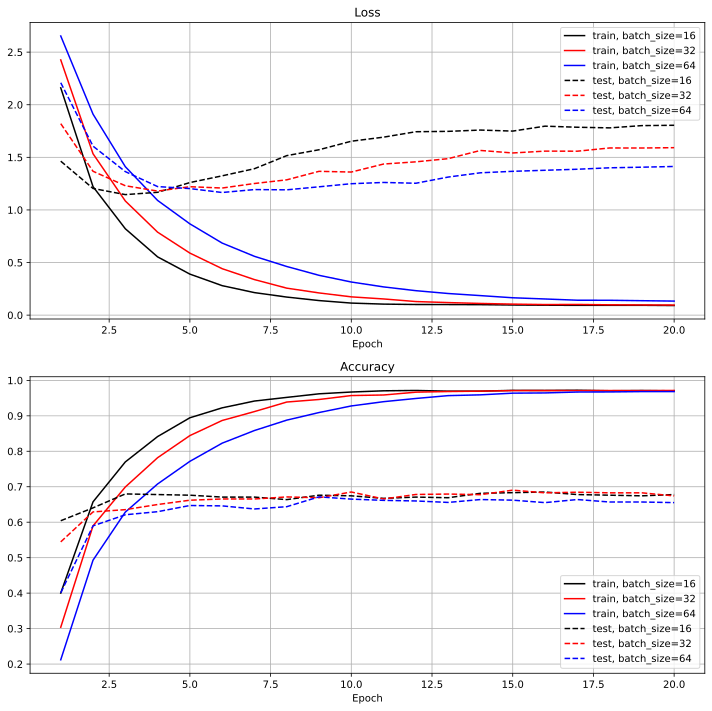

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

axes[0].plot(np.arange(20) + 1, loss_train[16], label='train, batch_size=16', linestyle='-', c='black')
axes[0].plot(np.arange(20) + 1, loss_train[32], label='train, batch_size=32', linestyle='-', c='r')
axes[0].plot(np.arange(20) + 1, loss_train[64], label='train, batch_size=64', linestyle='-', c='b')

axes[0].plot(np.arange(20) + 1, loss_test[16], label='test, batch_size=16', linestyle='--', c='black')
axes[0].plot(np.arange(20) + 1, loss_test[32], label='test, batch_size=32', linestyle='--', c='r')
axes[0].plot(np.arange(20) + 1, loss_test[64], label='test, batch_size=64', linestyle='--', c='b')

axes[1].plot(np.arange(20) + 1, acc_train[16], label='train, batch_size=16', linestyle='-', c='black')
axes[1].plot(np.arange(20) + 1, acc_train[32], label='train, batch_size=32', linestyle='-', c='r')
axes[1].plot(np.arange(20) + 1, acc_train[64], label='train, batch_size=64', linestyle='-', c='b')

axes[1].plot(np.arange(20) + 1, acc_test[16], label='test, batch_size=16', linestyle='--', c='black')
axes[1].plot(np.arange(20) + 1, acc_test[32], label='test, batch_size=32', linestyle='--', c='r')
axes[1].plot(np.arange(20) + 1, acc_test[64], label='test, batch_size=64', linestyle='--', c='b')

axes[0].legend()
axes[0].grid(True)
axes[0].set_xlabel('Epoch')
axes[0].set_title('Loss')

axes[1].legend()
axes[1].grid(True)
axes[1].set_xlabel('Epoch')
axes[1].set_title('Accuracy')

fig.tight_layout()
plt.show()

Отсюда видно, что качество лучше при batch_size=32 и 16, а loss лучший при batch_size=64 и 32. Поэтому для итогового трансформера будет использовать batch_size=32. Далее будем рассматривать LR.

In [ ]:
lrs = [5e-5, 4e-5, 3e-5, 2e-5]
lrs_dict = dict()
for lr in lrs:
    train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = 32 # Trains with this batch size.
        )

    # For validation the order doesn't matter, so we'll just read them sequentially.
    validation_dataloader = DataLoader(
                val_dataset, # The validation samples.
                sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
                batch_size = 32 # Evaluate with this batch size.
            )
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased', # Use the 12-layer BERT model, with an uncased vocab.
        num_labels = 20, # The number of output labels--2 for binary classification.
                        # You can increase this for multi-class tasks.   
        output_attentions = False, # Whether the model returns attentions weights.
        output_hidden_states = False, # Whether the model returns all hidden-states.
    )

    # Tell pytorch to run this model on the GPU.
    model.cuda()
    optimizer = AdamW(model.parameters(),
                  lr = lr, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )
    total_steps = len(train_dataloader) * epochs

    # Create the learning rate scheduler.
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps = 0, # Default value in run_glue.py
                                                num_training_steps = total_steps)
    lrs_dict[lr] = training(train_dataloader, validation_dataloader, optimizer, scheduler)

In [ ]:
show_table(lrs_dict[5e-5])

,Training Loss,Training Accur.,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,,
1,1.97,0.43,1.32,0.60,0:00:59,0:00:02
2,1.04,0.69,1.17,0.65,0:00:57,0:00:02
3,0.66,0.81,1.19,0.66,0:00:58,0:00:02
4,0.42,0.88,1.23,0.66,0:00:58,0:00:02
5,0.28,0.93,1.36,0.67,0:00:58,0:00:02
6,0.19,0.95,1.46,0.68,0:00:58,0:00:02
7,0.15,0.96,1.55,0.68,0:00:58,0:00:02
8,0.12,0.97,1.71,0.68,0:00:58,0:00:02
9,0.11,0.97,1.67,0.69,0:00:58,0:00:02


In [ ]:
show_table(lrs_dict[4e-5])

,Training Loss,Training Accur.,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,,
1,2.14,0.37,1.48,0.59,0:00:58,0:00:02
2,1.18,0.66,1.22,0.65,0:00:58,0:00:02
3,0.76,0.78,1.18,0.65,0:00:58,0:00:02
4,0.49,0.86,1.21,0.67,0:00:58,0:00:02
5,0.34,0.90,1.32,0.66,0:00:58,0:00:02
6,0.24,0.93,1.50,0.65,0:00:58,0:00:02
7,0.18,0.95,1.56,0.64,0:00:58,0:00:02
8,0.14,0.96,1.70,0.64,0:00:58,0:00:02
9,0.12,0.97,1.67,0.68,0:00:58,0:00:02


In [ ]:
show_table(lrs_dict[3e-5])

,Training Loss,Training Accur.,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,,
1,2.25,0.35,1.58,0.59,0:00:58,0:00:02
2,1.30,0.63,1.25,0.65,0:00:58,0:00:02
3,0.87,0.75,1.18,0.63,0:00:58,0:00:02
4,0.58,0.83,1.21,0.65,0:00:58,0:00:02
5,0.41,0.88,1.29,0.67,0:00:58,0:00:02
6,0.29,0.92,1.37,0.65,0:00:58,0:00:02
7,0.22,0.94,1.35,0.67,0:00:58,0:00:02
8,0.17,0.95,1.44,0.67,0:00:58,0:00:02
9,0.14,0.96,1.56,0.67,0:00:58,0:00:02


In [ ]:
show_table(lrs_dict[2e-5])

,Training Loss,Training Accur.,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,,
1,2.43,0.30,1.82,0.54,0:00:58,0:00:02
2,1.53,0.59,1.37,0.63,0:00:58,0:00:02
3,1.08,0.70,1.23,0.64,0:00:58,0:00:02
4,0.79,0.78,1.18,0.65,0:00:58,0:00:02
5,0.59,0.84,1.22,0.66,0:00:58,0:00:02
6,0.44,0.89,1.21,0.67,0:00:58,0:00:02
7,0.34,0.91,1.25,0.67,0:00:58,0:00:02
8,0.26,0.94,1.29,0.67,0:00:58,0:00:02
9,0.21,0.95,1.37,0.67,0:00:58,0:00:02


In [ ]:
loss_train = dict()
loss_test = dict()
acc_train = dict()
acc_test = dict()
for key in lrs_dict:
    for list_ in lrs_dict[key]:
        if key in loss_train:
            loss_train[key].append(list_['Training Loss'])
            loss_test[key].append(list_['Valid. Loss'])
            acc_test[key].append(list_['Valid. Accur.'])
            acc_train[key].append(list_['Training Accur.'])
        else:
            loss_train[key] = [list_['Training Loss']]
            loss_test[key] = [list_['Valid. Loss']]
            acc_test[key] = [list_['Valid. Accur.']]
            acc_train[key] = [list_['Training Accur.']]

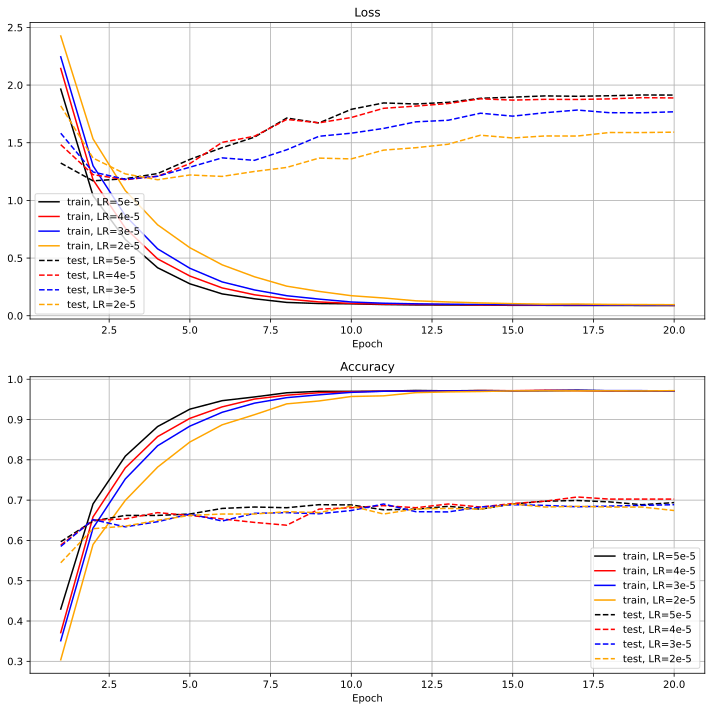

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

axes[0].plot(np.arange(20) + 1, loss_train[5e-5], label='train, LR=5e-5', linestyle='-', c='black')
axes[0].plot(np.arange(20) + 1, loss_train[4e-5], label='train, LR=4e-5', linestyle='-', c='r')
axes[0].plot(np.arange(20) + 1, loss_train[3e-5], label='train, LR=3e-5', linestyle='-', c='b')
axes[0].plot(np.arange(20) + 1, loss_train[2e-5], label='train, LR=2e-5', linestyle='-', c='orange')

axes[0].plot(np.arange(20) + 1, loss_test[5e-5], label='test, LR=5e-5', linestyle='--', c='black')
axes[0].plot(np.arange(20) + 1, loss_test[4e-5], label='test, LR=4e-5', linestyle='--', c='r')
axes[0].plot(np.arange(20) + 1, loss_test[3e-5], label='test, LR=3e-5', linestyle='--', c='b')
axes[0].plot(np.arange(20) + 1, loss_test[2e-5], label='test, LR=2e-5', linestyle='--', c='orange')

axes[1].plot(np.arange(20) + 1, acc_train[5e-5], label='train, LR=5e-5', linestyle='-', c='black')
axes[1].plot(np.arange(20) + 1, acc_train[4e-5], label='train, LR=4e-5', linestyle='-', c='r')
axes[1].plot(np.arange(20) + 1, acc_train[3e-5], label='train, LR=3e-5', linestyle='-', c='b')
axes[1].plot(np.arange(20) + 1, acc_train[2e-5], label='train, LR=2e-5', linestyle='-', c='orange')

axes[1].plot(np.arange(20) + 1, acc_test[5e-5], label='test, LR=5e-5', linestyle='--', c='black')
axes[1].plot(np.arange(20) + 1, acc_test[4e-5], label='test, LR=4e-5', linestyle='--', c='r')
axes[1].plot(np.arange(20) + 1, acc_test[3e-5], label='test, LR=3e-5', linestyle='--', c='b')
axes[1].plot(np.arange(20) + 1, acc_test[2e-5], label='test, LR=2e-5', linestyle='--', c='orange')

axes[0].legend()
axes[0].grid(True)
axes[0].set_xlabel('Epoch')
axes[0].set_title('Loss')

axes[1].legend()
axes[1].grid(True)
axes[1].set_xlabel('Epoch')
axes[1].set_title('Accuracy')

fig.tight_layout()
plt.show()

Затруднительно что-то сказать по графику accuracy, но по графику loss понятно, что надо брать 2e-5.

In [ ]:
max_lens = [25, 50, 70, 100]
ml_dict = dict()
for ml in max_lens:
    input_ids, attention_masks, labels = tokenizing(X_train, y_train, max_length=ml)
    dataset = TensorDataset(input_ids, attention_masks, labels)
    train_size = int(0.9 * len(dataset))
    val_size = len(dataset) - train_size

    # Divide the dataset by randomly selecting samples.
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = 32 # Trains with this batch size.
        )

    # For validation the order doesn't matter, so we'll just read them sequentially.
    validation_dataloader = DataLoader(
                val_dataset, # The validation samples.
                sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
                batch_size = 32 # Evaluate with this batch size.
            )
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased', # Use the 12-layer BERT model, with an uncased vocab.
        num_labels = 20, # The number of output labels--2 for binary classification.
                        # You can increase this for multi-class tasks.   
        output_attentions = False, # Whether the model returns attentions weights.
        output_hidden_states = False, # Whether the model returns all hidden-states.
    )

    # Tell pytorch to run this model on the GPU.
    model.cuda()
    optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )
    total_steps = len(train_dataloader) * epochs

    # Create the learning rate scheduler.
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps = 0, # Default value in run_glue.py
                                                num_training_steps = total_steps)
    ml_dict[ml] = training(train_dataloader, validation_dataloader, optimizer, scheduler)

In [ ]:
show_table(ml_dict[25])

In [ ]:
show_table(ml_dict[50])

In [ ]:
show_table(ml_dict[70])

,Training Loss,Training Accur.,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,,
1,2.50,0.27,1.80,0.52,0:01:08,0:00:03
2,1.51,0.58,1.39,0.60,0:01:07,0:00:03
3,1.06,0.71,1.25,0.62,0:01:07,0:00:03
4,0.76,0.80,1.23,0.62,0:01:07,0:00:03
5,0.57,0.85,1.20,0.64,0:01:07,0:00:03
6,0.41,0.90,1.20,0.66,0:01:07,0:00:03
7,0.30,0.93,1.27,0.66,0:01:07,0:00:03
8,0.23,0.95,1.31,0.66,0:01:07,0:00:03
9,0.18,0.96,1.44,0.65,0:01:07,0:00:03


In [ ]:
show_table(ml_dict[100])

,Training Loss,Training Accur.,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,,
1,2.45,0.30,1.72,0.55,0:01:32,0:00:04
2,1.42,0.62,1.30,0.64,0:01:31,0:00:04
3,0.98,0.74,1.15,0.66,0:01:31,0:00:04
4,0.71,0.81,1.14,0.66,0:01:32,0:00:04
5,0.51,0.87,1.16,0.68,0:01:32,0:00:04
6,0.37,0.91,1.15,0.68,0:01:31,0:00:04
7,0.27,0.94,1.22,0.68,0:01:31,0:00:04
8,0.20,0.95,1.25,0.69,0:01:32,0:00:04
9,0.16,0.96,1.32,0.69,0:01:31,0:00:04


In [ ]:
loss_train = dict()
loss_test = dict()
acc_train = dict()
acc_test = dict()
for key in ml_dict:
    for list_ in ml_dict[key]:
        if key in loss_train:
            loss_train[key].append(list_['Training Loss'])
            loss_test[key].append(list_['Valid. Loss'])
            acc_test[key].append(list_['Valid. Accur.'])
            acc_train[key].append(list_['Training Accur.'])
        else:
            loss_train[key] = [list_['Training Loss']]
            loss_test[key] = [list_['Valid. Loss']]
            acc_test[key] = [list_['Valid. Accur.']]
            acc_train[key] = [list_['Training Accur.']]

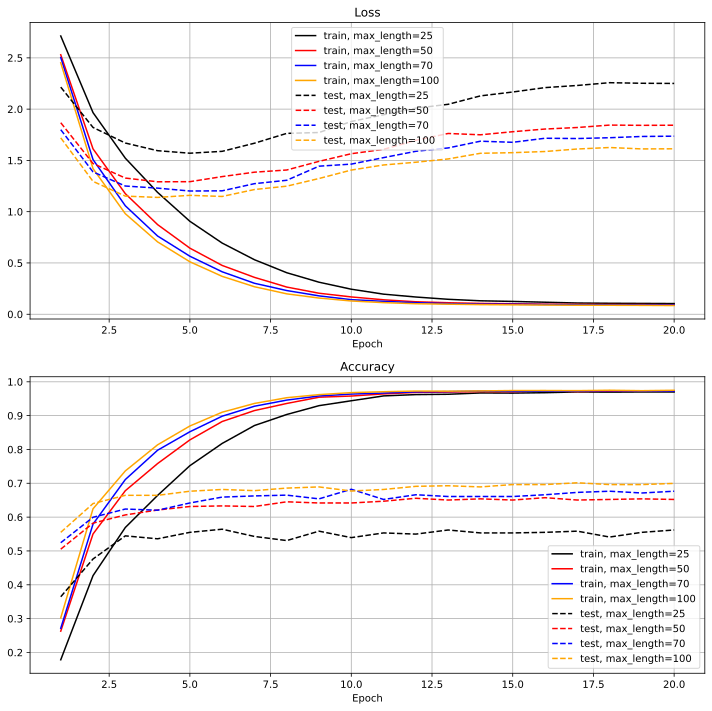

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

axes[0].plot(np.arange(20) + 1, loss_train[25], label='train, max_length=25', linestyle='-', c='black')
axes[0].plot(np.arange(20) + 1, loss_train[50], label='train, max_length=50', linestyle='-', c='r')
axes[0].plot(np.arange(20) + 1, loss_train[70], label='train, max_length=70', linestyle='-', c='b')
axes[0].plot(np.arange(20) + 1, loss_train[100], label='train, max_length=100', linestyle='-', c='orange')

axes[0].plot(np.arange(20) + 1, loss_test[25], label='test, max_length=25', linestyle='--', c='black')
axes[0].plot(np.arange(20) + 1, loss_test[50], label='test, max_length=50', linestyle='--', c='r')
axes[0].plot(np.arange(20) + 1, loss_test[70], label='test, max_length=70', linestyle='--', c='b')
axes[0].plot(np.arange(20) + 1, loss_test[100], label='test, max_length=100', linestyle='--', c='orange')

axes[1].plot(np.arange(20) + 1, acc_train[25], label='train, max_length=25', linestyle='-', c='black')
axes[1].plot(np.arange(20) + 1, acc_train[50], label='train, max_length=50', linestyle='-', c='r')
axes[1].plot(np.arange(20) + 1, acc_train[70], label='train, max_length=70', linestyle='-', c='b')
axes[1].plot(np.arange(20) + 1, acc_train[100], label='train, max_length=100', linestyle='-', c='orange')

axes[1].plot(np.arange(20) + 1, acc_test[25], label='test, max_length=25', linestyle='--', c='black')
axes[1].plot(np.arange(20) + 1, acc_test[50], label='test, max_length=50', linestyle='--', c='r')
axes[1].plot(np.arange(20) + 1, acc_test[70], label='test, max_length=70', linestyle='--', c='b')
axes[1].plot(np.arange(20) + 1, acc_test[100], label='test, max_length=100', linestyle='--', c='orange')

axes[0].legend()
axes[0].grid(True)
axes[0].set_xlabel('Epoch')
axes[0].set_title('Loss')

axes[1].legend()
axes[1].grid(True)
axes[1].set_xlabel('Epoch')
axes[1].set_title('Accuracy')

fig.tight_layout()
plt.show()

Из графиков следует, что и лучшее качество, и лучший loss получаются при max_length=100.

Попробуем поэкспериментировать с эпохами и рассмотрим 40 эпох, чтобы найти оптимальное значение.

In [ ]:
input_ids, attention_masks, labels = tokenizing(X_train, y_train, max_length=100)
dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_dataloader = DataLoader(
        train_dataset,  # The training samples.
        sampler = RandomSampler(train_dataset), # Select batches randomly
        batch_size = 32 # Trains with this batch size.
    )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = 32 # Evaluate with this batch size.
        )
model = BertForSequenceClassification.from_pretrained(
      'bert-base-uncased', # Use the 12-layer BERT model, with an uncased vocab.
      num_labels = 20, # The number of output labels--2 for binary classification.
                      # You can increase this for multi-class tasks.   
      output_attentions = False, # Whether the model returns attentions weights.
      output_hidden_states = False, # Whether the model returns all hidden-states.
  )

# Tell pytorch to run this model on the GPU.
model.cuda()
optimizer = AdamW(model.parameters(),
                lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
            )
total_steps = len(train_dataloader) * 40

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
res1 = training(train_dataloader, validation_dataloader, optimizer, scheduler, epochs=40)

In [ ]:
show_table(res1)

,Training Loss,Training Accur.,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,,
1,2.31,0.38,1.72,0.53,0:01:26,0:00:04
2,1.35,0.65,1.37,0.59,0:01:29,0:00:04
3,0.92,0.75,1.25,0.64,0:01:30,0:00:04
4,0.65,0.83,1.22,0.64,0:01:30,0:00:04
5,0.47,0.88,1.29,0.64,0:01:30,0:00:04
6,0.34,0.91,1.33,0.65,0:01:30,0:00:04
7,0.25,0.94,1.40,0.64,0:01:30,0:00:04
8,0.19,0.95,1.48,0.65,0:01:30,0:00:04
9,0.16,0.96,1.56,0.66,0:01:30,0:00:04


In [ ]:
loss_train = []
loss_test = []
acc_train = []
acc_test = []
for list_ in res1:
    loss_train.append(list_['Training Loss'])
    loss_test.append(list_['Valid. Loss'])
    acc_test.append(list_['Valid. Accur.'])
    acc_train.append(list_['Training Accur.'])

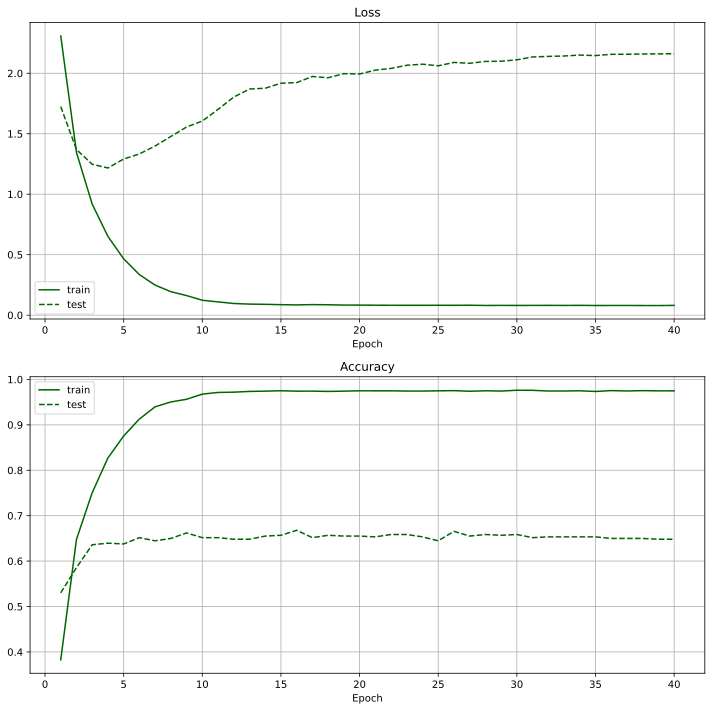

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

axes[0].plot(np.arange(40) + 1, loss_train, label='train', linestyle='-', c='darkgreen')

axes[0].plot(np.arange(40) + 1, loss_test, label='test', linestyle='--', c='darkgreen')

axes[1].plot(np.arange(40) + 1, acc_train, label='train', linestyle='-', c='darkgreen')

axes[1].plot(np.arange(40) + 1, acc_test, label='test', linestyle='--', c='darkgreen')

axes[0].legend()
axes[0].grid(True)
axes[0].set_xlabel('Epoch')
axes[0].set_title('Loss')

axes[1].legend()
axes[1].grid(True)
axes[1].set_xlabel('Epoch')
axes[1].set_title('Accuracy')

fig.tight_layout()
plt.show()

При 15 эпохах получается устойчивое качество и приемлемый loss. Так что остановимся на этом числе.

In [ ]:
input_ids, attention_masks, labels = tokenizing(X_test, y_test, max_length=100)
test_dataset = TensorDataset(input_ids, attention_masks, labels)
input_ids, attention_masks, labels = tokenizing(X_train, y_train, max_length=100)
dataset = TensorDataset(input_ids, attention_masks, labels)
train_dataloader = DataLoader(
        dataset,  # The training samples.
        sampler = RandomSampler(dataset), # Select batches randomly
        batch_size = 32 # Trains with this batch size.
    )

# For validation the order doesn't matter, so we'll just read them sequentially.
test_dataloader = DataLoader(
            test_dataset, # The validation samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = 32 # Evaluate with this batch size.
        )
model = BertForSequenceClassification.from_pretrained(
      'bert-base-uncased', # Use the 12-layer BERT model, with an uncased vocab.
      num_labels = 20, # The number of output labels--2 for binary classification.
                      # You can increase this for multi-class tasks.   
      output_attentions = False, # Whether the model returns attentions weights.
      output_hidden_states = False, # Whether the model returns all hidden-states.
  )

# Tell pytorch to run this model on the GPU.
model.cuda()
optimizer = AdamW(model.parameters(),
                lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
            )
total_steps = len(train_dataloader) * 15

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
res2 = training(train_dataloader, test_dataloader, optimizer, scheduler, epochs=15)

In [18]:
loss_train = []
loss_test = []
acc_train = []
acc_test = []
for list_ in res2:
    loss_train.append(list_['Training Loss'])
    loss_test.append(list_['Valid. Loss'])
    acc_test.append(list_['Valid. Accur.'])
    acc_train.append(list_['Training Accur.'])

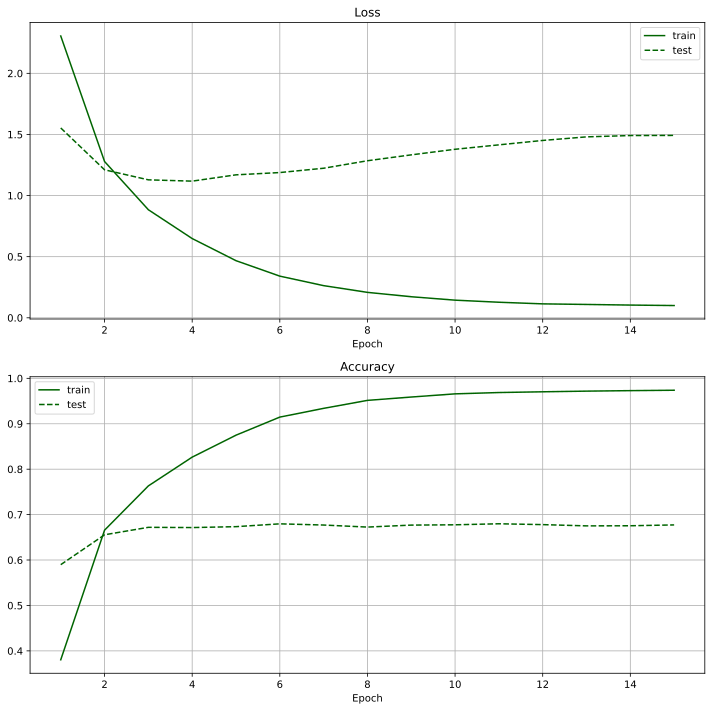

In [20]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

axes[0].plot(np.arange(15) + 1, loss_train, label='train', linestyle='-', c='darkgreen')

axes[0].plot(np.arange(15) + 1, loss_test, label='test', linestyle='--', c='darkgreen')

axes[1].plot(np.arange(15) + 1, acc_train, label='train', linestyle='-', c='darkgreen')

axes[1].plot(np.arange(15) + 1, acc_test, label='test', linestyle='--', c='darkgreen')

axes[0].legend()
axes[0].grid(True)
axes[0].set_xlabel('Epoch')
axes[0].set_title('Loss')

axes[1].legend()
axes[1].grid(True)
axes[1].set_xlabel('Epoch')
axes[1].set_title('Accuracy')

fig.tight_layout()
plt.show()

Качество получилось не идеальное, но, скорее всего, потому, что была взята слишком маленькая обучающая выборка.